In [1]:
# load dataset to checked its size, columns and preview

import pandas as pd
from google.colab import files

# Upload the dataset
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head()


Saving KOGI_crosschecked.csv to KOGI_crosschecked.csv
Shape: (2511, 19)
Columns: ['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters', 'Registered_Voters', 'Results_Found', 'Transcription_Count', 'Result_Sheet_Stamped', 'Result_Sheet_Corrected', 'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned', 'APC', 'LP', 'PDP', 'NNPP', 'Results_File']


,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,KOGI,ADAVI,OKUNCHI/OZURI/ONIEKA,22-01-01-002,NEAR OPOTUS COMPOUND II,84,341,True,-1,False,True,False,False,UNKNOWN,37,0,21,20,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
1,KOGI,ADAVI,OKUNCHI/OZURI/ONIEKA,22-01-01-005,LGEA SCHOOL OZURI I,149,493,True,-1,True,False,False,False,UNKNOWN,42,1,54,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
2,KOGI,ADAVI,OKUNCHI/OZURI/ONIEKA,22-01-01-008,OPPOSITE AJOGE'S HOUSE,134,590,True,-1,False,False,False,False,UNKNOWN,50,18,92,5,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
3,KOGI,ADAVI,OKUNCHI/OZURI/ONIEKA,22-01-01-010,FRONT OF VICTORY PRINTING OKUNCHI I,136,567,True,-1,False,False,False,False,UNKNOWN,53,4,55,0,https://docs.inecelectionresults.net/elections...
4,KOGI,ADAVI,OKUNCHI/OZURI/ONIEKA,22-01-01-011,FRONT OF VICTORY PRINTING OKUNCHI II,116,433,True,-1,False,False,False,False,UNKNOWN,53,4,55,0,https://docs.inecelectionresults.net/elections...


In [3]:
# assigning approximate coordinates by Ward/LGA

import geopandas as gpd
import pandas as pd

# Loading map of all LGAs in Nigeria
url = "https://raw.githubusercontent.com/qedsoftware/geojson_data/main/nigeria-lga.geojson"
lga_map = gpd.read_file(url)

# Keep only LGAs in Kogi State
kogi_lgas = lga_map[lga_map['NAME_1'].str.lower() == 'kogi'].copy()

# Reproject to a metric CRS for accurate centroid calculations
kogi_lgas = kogi_lgas.to_crs(epsg=3857)

# Calculating longitude & latitude of each LGA
kogi_lgas['centroid'] = kogi_lgas.geometry.centroid
kogi_lgas = kogi_lgas.set_geometry('centroid').to_crs(epsg=4326)
kogi_lgas['lon'] = kogi_lgas.geometry.x
kogi_lgas['lat'] = kogi_lgas.geometry.y

# Clean up LGA names for better matching
df['LGA_clean'] = df['LGA'].str.strip().str.lower()
kogi_lgas['NAME_2_clean'] = kogi_lgas['NAME_2'].str.strip().str.lower()

df = df.drop(columns=['lat', 'lon'], errors='ignore')

# Merging coordinates into the data
df = df.merge(
    kogi_lgas[['NAME_2_clean','lat','lon']],
    how='left',
    left_on='LGA_clean',
    right_on='NAME_2_clean'
)

print("Polling units with coords:", df['lat'].notna().sum(), "of", len(df))

# Saving the dataset with coordinates
df.to_csv('KOGI_with_coords.csv', index=False)
print("File saved as KOGI_with_coords.csv")


Polling units with coords: 2028 of 2511
File saved as KOGI_with_coords.csv


In [5]:
# identifying neighbouring polling units (within 1 km)

import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# loading the dataset with coordinates
df = pd.read_csv('KOGI_with_coords.csv')

# defining a helper function to calculate distance (Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of Earth in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# for each polling unit, find neighbours within 1 km
neighbours_list = []
for i, row1 in df.iterrows():
    nearby = []
    for j, row2 in df.iterrows():
        if i != j and pd.notna(row1['lat']) and pd.notna(row2['lat']):
            dist = haversine(row1['lat'], row1['lon'], row2['lat'], row2['lon'])
            if dist <= 1:  # within 1 km radius
                nearby.append(row2['PU-Code'])
    neighbours_list.append(nearby)

# adding the neighbours as a new column
df['neighbours_within_1km'] = neighbours_list


df.to_csv('KOGI_with_neighbours.csv', index=False)

print("Neighbour identification complete.")
print("File saved as KOGI_with_neighbours.csv")


Neighbour identification complete.
File saved as KOGI_with_neighbours.csv


In [6]:
# calculating outlier scores for each party

import pandas as pd
import numpy as np

df = pd.read_csv('KOGI_with_neighbours.csv')

# convert the string list of neighbours back to actual Python lists
df['neighbours_within_1km'] = df['neighbours_within_1km'].apply(
    lambda x: [] if pd.isna(x) else [n.strip().strip("'") for n in x.strip('[]').split(',') if n.strip()]
)

parties = ['APC', 'LP', 'PDP', 'NNPP']

# create columns for outlier scores
for party in parties:
    scores = []
    for i, row in df.iterrows():
        neighbours = df[df['PU-Code'].isin(row['neighbours_within_1km'])]
        if not neighbours.empty:
            local_mean = neighbours[party].mean()
            score = abs(row[party] - local_mean)
        else:
            score = np.nan
        scores.append(score)
    df[f'{party}_outlier_score'] = scores


df.to_csv('KOGI_with_outlier_scores.csv', index=False)

print("Outlier scores calculated successfully.")
print("File saved as KOGI_with_outlier_scores.csv")


Outlier scores calculated successfully.
File saved as KOGI_with_outlier_scores.csv


In [8]:
# sorting polling units by outlier scores for each party

import pandas as pd

# loading the file with outlier scores
df = pd.read_csv('KOGI_with_outlier_scores.csv')


parties = ['APC', 'LP', 'PDP', 'NNPP']

# for each party, sort by the outlier score
for party in parties:
    sorted_party = df[['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', party, f'{party}_outlier_score', 'lat', 'lon']].sort_values(
        by=f'{party}_outlier_score', ascending=False
    )
    filename = f'top_outliers_{party}.csv'
    sorted_party.to_csv(filename, index=False)
    print(f"Top outliers for {party} saved as {filename}")

# saved a combined sorted file for overview
combined = df.sort_values(
    by=[f'{p}_outlier_score' for p in parties],
    ascending=[False]*len(parties)
)
combined.to_csv('KOGI_all_outliers_sorted.csv', index=False)

print("All-party sorted file saved as KOGI_all_outliers_sorted.csv")


Top outliers for APC saved as top_outliers_APC.csv
Top outliers for LP saved as top_outliers_LP.csv
Top outliers for PDP saved as top_outliers_PDP.csv
Top outliers for NNPP saved as top_outliers_NNPP.csv
All-party sorted file saved as KOGI_all_outliers_sorted.csv


 APC static map saved as KOGI_APC_outliers_static.png


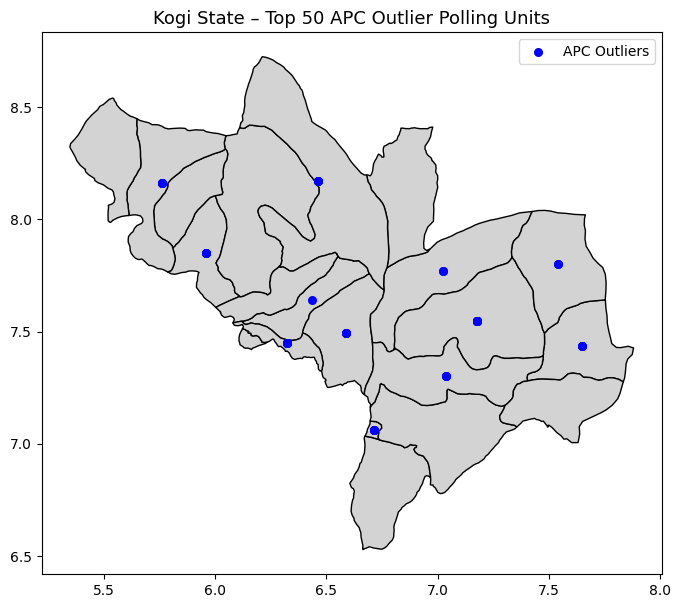

 LP static map saved as KOGI_LP_outliers_static.png


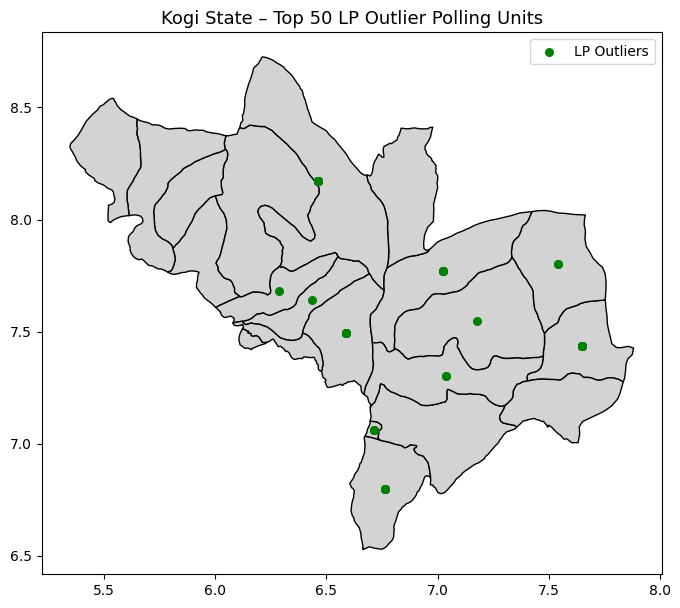

 PDP static map saved as KOGI_PDP_outliers_static.png


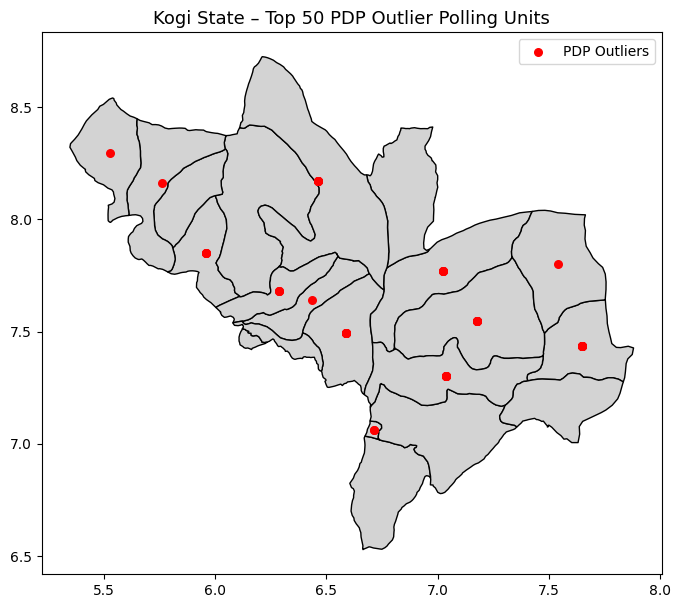

 NNPP static map saved as KOGI_NNPP_outliers_static.png


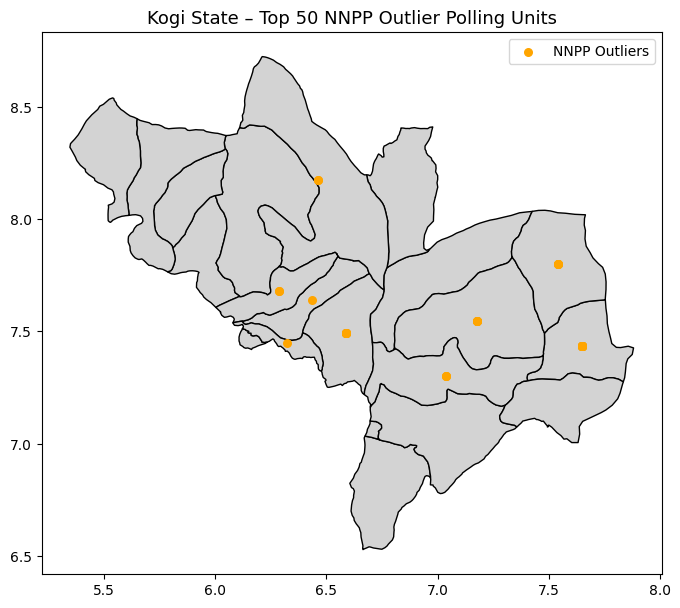

In [20]:
# Visualizing APC, LP, PDP, NNPP Outliers on Static Maps

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Loading outlier dataset
df = pd.read_csv('KOGI_all_outliers_sorted.csv')

# Converting the data to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs='EPSG:4326')

# Loading map of Nigeria LGAs for background
url = "https://raw.githubusercontent.com/qedsoftware/geojson_data/main/nigeria-lga.geojson"
lga_map = gpd.read_file(url)

# Keeping only LGAs in Kogi State
kogi_lgas = lga_map[lga_map['NAME_1'].str.lower() == 'kogi']

# Define colors for each party
party_colors = {
    'APC': 'blue',
    'LP': 'green',
    'PDP': 'red',
    'NNPP': 'orange'
}

# Creating and saving maps for each party
for party, color in party_colors.items():

    # Keep valid coordinates and take top 50 outliers
    subset = gdf[gdf['lat'].notna()].nlargest(50, f'{party}_outlier_score')

    # Creating a new figure
    fig, ax = plt.subplots(figsize=(8, 8))

    kogi_lgas.plot(ax=ax, color='lightgrey', edgecolor='black')

    subset.plot(ax=ax, color=color, markersize=30, label=f'{party} Outliers')

    # title and legend
    plt.title(f'Kogi State – Top 50 {party} Outlier Polling Units', fontsize=13)
    plt.legend()

    # Saving the figure
    plt.savefig(f'KOGI_{party}_outliers_static.png', dpi=300, bbox_inches='tight')
    print(f" {party} static map saved as KOGI_{party}_outliers_static.png")

    plt.show()


In [24]:
# Top 3 Outliers for APC, LP, PDP and NNPP

import pandas as pd
df = pd.read_csv('KOGI_all_outliers_sorted.csv')
parties = ['APC','LP','PDP','NNPP']
all_top3 = {}
for p in parties:
    top3 = df.nlargest(3, f'{p}_outlier_score')[['PU-Name','PU-Code','LGA','lat','lon',p,f'{p}_outlier_score']]
    top3.to_csv(f'top3_{p}.csv', index=False)
    all_top3[p] = top3
    print(f"\nTop 3 for {p}:\n", top3.to_string(index=False))

# Saving the combined top 3 file
combined = pd.concat([all_top3[p].assign(party=p) for p in parties], ignore_index=True)
combined.to_csv('top3_all_parties.csv', index=False)
print("\nSaved top3 CSVs and combined file: top3_all_parties.csv")



Top 3 for APC:
                    PU-Name      PU-Code    LGA      lat      lon  APC  APC_outlier_score
AJAGWUMU LGEA PRIM. SCHOOL 22-05-05-004 DEKINA 7.548202 7.176579  517         451.889328
    AGINI/ BUZHI LGEA SCH. 22-12-06-001 LOKOJA 8.173234 6.460267  500         443.000000
R.C.C. SCHOOL - UPOGORO IV 22-17-11-004  OKENE 7.449833 6.322079  366         286.544186

Top 3 for LP:
                                                      PU-Name      PU-Code      LGA      lat      lon  LP  LP_outlier_score
                                   OPEN SPACE ETUTU-EKPE ATE 22-05-02-033   DEKINA 7.548202 7.176579 565        559.592885
                                    LGEA SCH. GANAJA VILLAGE 22-02-14-009 AJAOKUTA 7.494071 6.589822 491        465.508772
UNITY LAYOUT, BEHIND FIRST 200 UNITY BY TRANSFORMER JUNCTION 22-02-14-049 AJAOKUTA 7.494071 6.589822 185        156.824561

Top 3 for PDP:
                             PU-Name      PU-Code      LGA      lat      lon  PDP  PDP_outlier_score
  

In [25]:
# Clean and organized dataset to include neighbours and outlier scores

import pandas as pd
df = pd.read_csv('KOGI_with_outlier_scores.csv')
cols = ['State','LGA','Ward','PU-Code','PU-Name','lat','lon','neighbours_within_1km',
        'APC','APC_outlier_score','LP','LP_outlier_score','PDP','PDP_outlier_score','NNPP','NNPP_outlier_score']
final = df[cols]
final.to_csv('KOGI_outlier_scores_with_neighbours.csv', index=False)

# Saved for Excel
final.to_excel('KOGI_outlier_scores_with_neighbours.xlsx', index=False)
print("Saved KOGI_outlier_scores_with_neighbours.csv and .xlsx")


Saved KOGI_outlier_scores_with_neighbours.csv and .xlsx


In [26]:
# Downloading final files

from google.colab import files
files.download('KOGI_outlier_scores_with_neighbours.csv')
files.download('KOGI_outlier_scores_with_neighbours.xlsx')
files.download('top3_all_parties.csv')
files.download('KOGI_APC_outliers_static.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>